# Predicting power consuption on Civil Building in 2019
by Eduardo Ferreira 105809

#### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sb
import plotly.express as px
import holidays
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import stats
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Reading the dataframes

In [2]:
df_raw_2017 = pd.read_csv('IST_Civil_Pav_2017_Ene_Cons - IST_Civil_Pav_2017_Ene_Cons.csv')
df_raw_2018 = pd.read_csv('IST_Civil_Pav_2018_Ene_Cons - IST_Civil_Pav_2018_Ene_Cons.csv')
df_raw_meteo = pd.read_csv('meteo_data.csv')

## Dataframes' overview

#### Quick dataframe description

In [3]:
df_raw_meteo.info(), print('\n'), df_raw_2017.info(), print('\n'), df_raw_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time                     17520 non-null  object 
 1   temperature_2m (°C)      17520 non-null  float64
 2   relativehumidity_2m (%)  17520 non-null  int64  
 3   precipitation (mm)       17520 non-null  float64
 4   direct_radiation (W/m²)  17520 non-null  float64
 5   windspeed_10m (m/s)      17520 non-null  float64
 6   windgusts_10m (m/s)      17520 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 958.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date_start  8760 non-null   object 
 1   Power_kW    8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB


<class 'pandas

(None, None, None, None, None)

#### Visualizing the dataframes

In [4]:
df_raw_2017

Date_start   Power_kW
0        1-1-2017 0:00  74.897706
1        1-1-2017 1:00  75.173557
2        1-1-2017 2:00  74.208175
3        1-1-2017 3:00  73.735889
4        1-1-2017 4:00  75.102351
...                ...        ...
8755  31-12-2017 19:00  64.309819
8756  31-12-2017 20:00  62.502569
8757  31-12-2017 21:00  61.209794
8758  31-12-2017 22:00  59.363600
8759  31-12-2017 23:00  58.580910

[8760 rows x 2 columns]

In [5]:
df_raw_2018

Date_start   Power_kW
0        1-1-2018 0:00  59.206871
1        1-1-2018 1:00  55.996697
2        1-1-2018 2:00  55.846459
3        1-1-2018 3:00  55.688012
4        1-1-2018 4:00  56.716963
...                ...        ...
8755  31-12-2018 19:00  99.453746
8756  31-12-2018 20:00  83.188111
8757  31-12-2018 21:00  82.704752
8758  31-12-2018 22:00  80.618406
8759  31-12-2018 23:00  75.092424

[8760 rows x 2 columns]

In [6]:
df_raw_meteo

time  temperature_2m (°C)  relativehumidity_2m (%)  \
0      2017-01-01T00:00                  7.4                       92   
1      2017-01-01T01:00                  7.3                       92   
2      2017-01-01T02:00                  7.0                       92   
3      2017-01-01T03:00                  6.8                       92   
4      2017-01-01T04:00                  6.1                       94   
...                 ...                  ...                      ...   
17515  2018-12-31T19:00                 11.9                       82   
17516  2018-12-31T20:00                 10.8                       86   
17517  2018-12-31T21:00                 10.2                       86   
17518  2018-12-31T22:00                  9.6                       86   
17519  2018-12-31T23:00                  9.1                       87   

       precipitation (mm)  direct_radiation (W/m²)  windspeed_10m (m/s)  \
0                     0.0                      0.0                 2.32   
1                     0.0                      0.0                 2.30   
2                     0.0                      0.0                 2.20   
3                     0.0                      0.0                 2.20   
4                     0.0                      0.0                 2.10   
...                   ...                      ...                  ...   
17515                 0.0                      0.0                 1.77   
17516                 0.0                      0.0                 1.98   
17517                 0.0                      0.0                 2.34   
17518                 0.0                      0.0                 2.42   
17519                 0.0                      0.0                 2.37   

       windgusts_10m (m/s)  
0                      4.2  
1                      4.3  
2                      4.3  
3                      4.4  
4                      4.6  
...                    ...  
17515                  2.6  
17516                  3.0  
17517                  3.6  
17518                  4.1  
17519                  4.3  

[17520 rows x 7 columns]

## Joining Data

#### Joining 2017 and 2018 power consuption measurements

In [7]:
df_raw = pd.concat([df_raw_2017, df_raw_2018]) #joins 2017 and 2018 data into a single table
df_raw = df_raw.reset_index(drop=True) #reset index from 0 to len(df_raw)

#### Changing the dataframes' indexes to dates

In [8]:
df_raw['Date_start'] = pd.to_datetime(df_raw['Date_start']) #converts 'obj' type to 'date' type
df_clean = df_raw.set_index(['Date_start'], drop = True) #sets the index as the date

In [9]:
#df_raw_meteo['time'] = pd.to_datetime(df_raw_meteo['time']) #converts 'obj' type to 'date' type
df_raw_meteo['time'] = pd.to_datetime(df_raw_meteo['time']) #converts 'obj' type to 'date' type
df_clean_meteo = df_raw_meteo.set_index(['time'], drop = True) #sets the index as the date

#### Matching power and meteorology time gaps

In [10]:
df_clean_meteo_test = df_clean_meteo.resample('H').mean() #getting the meteo values averaged after every hour ('H')
df_clean_meteo_test['temperature_2m (°C)'] = df_clean_meteo_test['temperature_2m (°C)']

print(df_clean_meteo_test['temperature_2m (°C)'].isnull().sum()) #checking if there's missing values

fig = px.line(df_clean_meteo_test, x = df_clean_meteo_test.index.date, y = df_clean_meteo_test['temperature_2m (°C)'])
fig.show() #plotting temperature

0


#### Joining power and meteorological data

In [11]:
df = df_clean.join(df_clean_meteo_test)
df #now we have every measure (power, temp, hr, ...) from hour to hour

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-01-01 00:00:00  74.897706                  7.4                     92.0   
2017-01-01 01:00:00  75.173557                  7.3                     92.0   
2017-01-01 02:00:00  74.208175                  7.0                     92.0   
2017-01-01 03:00:00  73.735889                  6.8                     92.0   
2017-01-01 04:00:00  75.102351                  6.1                     94.0   
...                        ...                  ...                      ...   
2018-12-31 19:00:00  99.453746                 11.9                     82.0   
2018-12-31 20:00:00  83.188111                 10.8                     86.0   
2018-12-31 21:00:00  82.704752                 10.2                     86.0   
2018-12-31 22:00:00  80.618406                  9.6                     86.0   
2018-12-31 23:00:00  75.092424                  9.1                     87.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-01-01 00:00:00                 0.0                      0.0   
2017-01-01 01:00:00                 0.0                      0.0   
2017-01-01 02:00:00                 0.0                      0.0   
2017-01-01 03:00:00                 0.0                      0.0   
2017-01-01 04:00:00                 0.0                      0.0   
...                                 ...                      ...   
2018-12-31 19:00:00                 0.0                      0.0   
2018-12-31 20:00:00                 0.0                      0.0   
2018-12-31 21:00:00                 0.0                      0.0   
2018-12-31 22:00:00                 0.0                      0.0   
2018-12-31 23:00:00                 0.0                      0.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  
2017-01-01 00:00:00                 2.32                  4.2  
2017-01-01 01:00:00                 2.30                  4.3  
2017-01-01 02:00:00                 2.20                  4.3  
2017-01-01 03:00:00                 2.20                  4.4  
2017-01-01 04:00:00                 2.10                  4.6  
...                                  ...                  ...  
2018-12-31 19:00:00                 1.77                  2.6  
2018-12-31 20:00:00                 1.98                  3.0  
2018-12-31 21:00:00                 2.34                  3.6  
2018-12-31 22:00:00                 2.42                  4.1  
2018-12-31 23:00:00                 2.37                  4.3  

[17520 rows x 7 columns]

#### Adding holidays and weekdays to the dataframe

In [12]:
holidays_PT = holidays.PT(2017, 2018) #gives out a dictionary with the holidays from 2017 and 2018
holiday_list = list(holidays_PT.keys()) #create a list of the holidays dates from 2017 and 2018

df['Holiday'] = 0 #creating a collum to state if each day is a holiday (value = 1) or not (value = 0)
for i in holiday_list:
    df.loc[df.index.date == i, 'Holiday'] = 1

df['Week Day']=df.index.dayofweek #monday is 0, (...), sunday is 6
df['Hour']=df.index.hour

df

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-01-01 00:00:00  74.897706                  7.4                     92.0   
2017-01-01 01:00:00  75.173557                  7.3                     92.0   
2017-01-01 02:00:00  74.208175                  7.0                     92.0   
2017-01-01 03:00:00  73.735889                  6.8                     92.0   
2017-01-01 04:00:00  75.102351                  6.1                     94.0   
...                        ...                  ...                      ...   
2018-12-31 19:00:00  99.453746                 11.9                     82.0   
2018-12-31 20:00:00  83.188111                 10.8                     86.0   
2018-12-31 21:00:00  82.704752                 10.2                     86.0   
2018-12-31 22:00:00  80.618406                  9.6                     86.0   
2018-12-31 23:00:00  75.092424                  9.1                     87.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-01-01 00:00:00                 0.0                      0.0   
2017-01-01 01:00:00                 0.0                      0.0   
2017-01-01 02:00:00                 0.0                      0.0   
2017-01-01 03:00:00                 0.0                      0.0   
2017-01-01 04:00:00                 0.0                      0.0   
...                                 ...                      ...   
2018-12-31 19:00:00                 0.0                      0.0   
2018-12-31 20:00:00                 0.0                      0.0   
2018-12-31 21:00:00                 0.0                      0.0   
2018-12-31 22:00:00                 0.0                      0.0   
2018-12-31 23:00:00                 0.0                      0.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Holiday  \
2017-01-01 00:00:00                 2.32                  4.2        1   
2017-01-01 01:00:00                 2.30                  4.3        1   
2017-01-01 02:00:00                 2.20                  4.3        1   
2017-01-01 03:00:00                 2.20                  4.4        1   
2017-01-01 04:00:00                 2.10                  4.6        1   
...                                  ...                  ...      ...   
2018-12-31 19:00:00                 1.77                  2.6        0   
2018-12-31 20:00:00                 1.98                  3.0        0   
2018-12-31 21:00:00                 2.34                  3.6        0   
2018-12-31 22:00:00                 2.42                  4.1        0   
2018-12-31 23:00:00                 2.37                  4.3        0   

                     Week Day  Hour  
2017-01-01 00:00:00         6     0  
2017-01-01 01:00:00         6     1  
2017-01-01 02:00:00         6     2  
2017-01-01 03:00:00         6     3  
2017-01-01 04:00:00         6     4  
...                       ...   ...  
2018-12-31 19:00:00         0    19  
2018-12-31 20:00:00         0    20  
2018-12-31 21:00:00         0    21  
2018-12-31 22:00:00         0    22  
2018-12-31 23:00:00         0    23  

[17520 rows x 10 columns]

In [13]:
df['Day off'] = 0 #merging weekends and holidays into a single column

for i in range(len(df)):
    if df['Holiday'][i] == 1 or df['Week Day'][i] > 4:
        df['Day off'][i] = 1 
        
df.drop(columns=["Holiday", "Week Day"], inplace=True) #this columns are no longer necessary
df

C:\Users\eduar\AppData\Local\Temp\ipykernel_15468\1383704564.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-01-01 00:00:00  74.897706                  7.4                     92.0   
2017-01-01 01:00:00  75.173557                  7.3                     92.0   
2017-01-01 02:00:00  74.208175                  7.0                     92.0   
2017-01-01 03:00:00  73.735889                  6.8                     92.0   
2017-01-01 04:00:00  75.102351                  6.1                     94.0   
...                        ...                  ...                      ...   
2018-12-31 19:00:00  99.453746                 11.9                     82.0   
2018-12-31 20:00:00  83.188111                 10.8                     86.0   
2018-12-31 21:00:00  82.704752                 10.2                     86.0   
2018-12-31 22:00:00  80.618406                  9.6                     86.0   
2018-12-31 23:00:00  75.092424                  9.1                     87.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-01-01 00:00:00                 0.0                      0.0   
2017-01-01 01:00:00                 0.0                      0.0   
2017-01-01 02:00:00                 0.0                      0.0   
2017-01-01 03:00:00                 0.0                      0.0   
2017-01-01 04:00:00                 0.0                      0.0   
...                                 ...                      ...   
2018-12-31 19:00:00                 0.0                      0.0   
2018-12-31 20:00:00                 0.0                      0.0   
2018-12-31 21:00:00                 0.0                      0.0   
2018-12-31 22:00:00                 0.0                      0.0   
2018-12-31 23:00:00                 0.0                      0.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  
2017-01-01 00:00:00                 2.32                  4.2     0        1  
2017-01-01 01:00:00                 2.30                  4.3     1        1  
2017-01-01 02:00:00                 2.20                  4.3     2        1  
2017-01-01 03:00:00                 2.20                  4.4     3        1  
2017-01-01 04:00:00                 2.10                  4.6     4        1  
...                                  ...                  ...   ...      ...  
2018-12-31 19:00:00                 1.77                  2.6    19        0  
2018-12-31 20:00:00                 1.98                  3.0    20        0  
2018-12-31 21:00:00                 2.34                  3.6    21        0  
2018-12-31 22:00:00                 2.42                  4.1    22        0  
2018-12-31 23:00:00                 2.37                  4.3    23        0  

[17520 rows x 9 columns]

### Quick statistics overview 

In [14]:
df.describe()

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
count  17520.000000         17520.000000             17520.000000   
mean     173.799188            16.671524                71.994692   
std      105.976077             5.561856                17.064924   
min        0.000000             2.300000                14.000000   
25%       95.907158            12.600000                60.000000   
50%      121.014087            16.000000                75.000000   
75%      266.680809            20.000000                86.000000   
max      507.359512            40.500000               100.000000   

       precipitation (mm)  direct_radiation (W/m²)  windspeed_10m (m/s)  \
count        17520.000000             17520.000000         17520.000000   
mean             0.054697               150.947603             4.829596   
std              0.289908               229.617914             2.155795   
min              0.000000                 0.000000             0.100000   
25%              0.000000                 0.000000             3.200000   
50%              0.000000                 2.000000             4.610000   
75%              0.000000               253.250000             6.320000   
max              9.800000               899.000000            15.670000   

       windgusts_10m (m/s)          Hour       Day off  
count         17520.000000  17520.000000  17520.000000  
mean              8.352089     11.500000      0.300000  
std               3.521206      6.922384      0.458271  
min               1.100000      0.000000      0.000000  
25%               5.700000      5.750000      0.000000  
50%               7.900000     11.500000      0.000000  
75%              10.700000     17.250000      1.000000  
max              28.000000     23.000000      1.000000

### Checking for outliers

#### Visually

In [15]:
# In Power
df_sort_power = df.sort_values(by = 'Power_kW', ascending = False)
df_sort_power [:10] # view first 10 entries
## Note: no obvious outliers

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-06-19 15:00:00  507.359512                 34.5                     31.0   
2017-06-19 16:00:00  494.649771                 33.3                     36.0   
2017-06-20 15:00:00  493.843028                 29.9                     45.0   
2017-06-20 14:00:00  491.637942                 30.3                     43.0   
2018-09-24 14:00:00  488.778451                 34.2                     24.0   
2018-09-26 14:00:00  485.859781                 31.1                     39.0   
2017-06-20 16:00:00  485.450873                 28.7                     50.0   
2018-09-25 14:00:00  483.930736                 29.5                     39.0   
2017-06-19 14:00:00  483.119030                 34.5                     30.0   
2018-02-26 12:00:00  482.851006                 16.3                     53.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-06-19 15:00:00                 0.0                    759.0   
2017-06-19 16:00:00                 0.0                    643.0   
2017-06-20 15:00:00                 0.0                    723.0   
2017-06-20 14:00:00                 0.0                    783.0   
2018-09-24 14:00:00                 0.0                    656.0   
2018-09-26 14:00:00                 0.0                    631.0   
2017-06-20 16:00:00                 0.0                    574.0   
2018-09-25 14:00:00                 0.0                    626.0   
2017-06-19 14:00:00                 0.0                    823.0   
2018-02-26 12:00:00                 0.0                    148.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  
2017-06-19 15:00:00                 3.96                  5.7    15        0  
2017-06-19 16:00:00                 4.54                  6.3    16        0  
2017-06-20 15:00:00                 4.02                  6.7    15        0  
2017-06-20 14:00:00                 4.03                  6.0    14        0  
2018-09-24 14:00:00                 4.00                  6.6    14        0  
2018-09-26 14:00:00                 1.65                  5.1    14        0  
2017-06-20 16:00:00                 3.89                  6.8    16        0  
2018-09-25 14:00:00                 2.28                  5.7    14        0  
2017-06-19 14:00:00                 3.55                  6.2    14        0  
2018-02-26 12:00:00                 5.88                 12.3    12        0

In [16]:
# In Power
df_sort_power = df.sort_values(by = 'Power_kW', ascending = True)
df_sort_power [:10] # view first 10 entries
## Note: appears like outliers - needs further checking.

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2018-01-14 05:00:00       0.0                  9.1                     83.0   
2018-10-01 12:00:00       0.0                 27.8                     39.0   
2018-10-01 11:00:00       0.0                 26.1                     47.0   
2018-10-01 10:00:00       0.0                 23.6                     59.0   
2018-10-01 09:00:00       0.0                 20.9                     72.0   
2018-10-01 08:00:00       0.0                 18.4                     86.0   
2018-10-01 07:00:00       0.0                 17.3                     92.0   
2018-10-01 06:00:00       0.0                 17.7                     91.0   
2018-10-01 05:00:00       0.0                 17.7                     91.0   
2018-10-01 13:00:00       0.0                 28.7                     34.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2018-01-14 05:00:00                 0.0                      0.0   
2018-10-01 12:00:00                 0.0                    639.0   
2018-10-01 11:00:00                 0.0                    550.0   
2018-10-01 10:00:00                 0.0                    416.0   
2018-10-01 09:00:00                 0.0                    238.0   
2018-10-01 08:00:00                 0.0                     75.0   
2018-10-01 07:00:00                 0.0                      2.0   
2018-10-01 06:00:00                 0.0                      0.0   
2018-10-01 05:00:00                 0.0                      0.0   
2018-10-01 13:00:00                 0.0                    667.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  
2018-01-14 05:00:00                 4.80                  7.7     5        1  
2018-10-01 12:00:00                 4.49                  7.2    12        0  
2018-10-01 11:00:00                 3.77                  7.1    11        0  
2018-10-01 10:00:00                 3.40                  7.1    10        0  
2018-10-01 09:00:00                 4.00                  7.1     9        0  
2018-10-01 08:00:00                 4.10                  7.0     8        0  
2018-10-01 07:00:00                 4.24                  6.8     7        0  
2018-10-01 06:00:00                 4.00                  5.8     6        0  
2018-10-01 05:00:00                 3.64                  5.7     5        0  
2018-10-01 13:00:00                 4.87                  7.8    13        0

In [17]:
# In temp
df_sort_temp = df.sort_values(by = 'temperature_2m (°C)', ascending = False)
df_sort_temp [:10] # view first 10 entries
## Note: no obvious outliers

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2018-08-04 13:00:00   98.658074                 40.5                     20.0   
2018-08-04 14:00:00  101.884857                 40.2                     21.0   
2018-08-04 12:00:00   95.393875                 40.0                     21.0   
2018-08-04 16:00:00  109.287196                 39.9                     19.0   
2018-08-04 15:00:00  106.632731                 39.7                     21.0   
2018-08-04 17:00:00  112.539177                 39.5                     19.0   
2018-08-02 13:00:00  424.446487                 39.2                     16.0   
2018-08-02 14:00:00  410.775947                 39.1                     16.0   
2018-08-04 11:00:00   98.025241                 38.7                     24.0   
2018-08-03 14:00:00  416.602979                 38.6                     18.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2018-08-04 13:00:00                 0.0                    829.0   
2018-08-04 14:00:00                 0.0                    817.0   
2018-08-04 12:00:00                 0.0                    789.0   
2018-08-04 16:00:00                 0.0                    492.0   
2018-08-04 15:00:00                 0.0                    664.0   
2018-08-04 17:00:00                 0.0                    449.0   
2018-08-02 13:00:00                 0.0                    694.0   
2018-08-02 14:00:00                 0.0                    772.0   
2018-08-04 11:00:00                 0.0                    697.0   
2018-08-03 14:00:00                 0.0                    815.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  
2018-08-04 13:00:00                 3.13                  6.6    13        1  
2018-08-04 14:00:00                 4.12                  8.2    14        1  
2018-08-04 12:00:00                 2.70                  5.6    12        1  
2018-08-04 16:00:00                 5.23                  8.8    16        1  
2018-08-04 15:00:00                 4.84                  8.9    15        1  
2018-08-04 17:00:00                 5.26                  8.2    17        1  
2018-08-02 13:00:00                 1.98                  5.7    13        0  
2018-08-02 14:00:00                 2.78                  6.3    14        0  
2018-08-04 11:00:00                 2.67                  5.4    11        1  
2018-08-03 14:00:00                 2.48                  4.8    14        0

In [18]:
# In temp
df_sort_temp = df.sort_values(by = 'temperature_2m (°C)', ascending = True)
df_sort_temp [:10] # view first 10 entries
## Note: no obvious outliers

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-01-19 08:00:00  316.689546                  2.3                     63.0   
2017-01-19 07:00:00  196.812746                  2.4                     63.0   
2017-01-19 06:00:00  128.110317                  2.6                     63.0   
2017-01-19 05:00:00  115.475792                  2.7                     63.0   
2017-01-19 09:00:00  353.867703                  2.8                     62.0   
2017-01-19 04:00:00  103.405185                  2.9                     63.0   
2017-01-19 03:00:00  102.135509                  3.2                     62.0   
2017-01-19 02:00:00  110.055950                  3.5                     62.0   
2018-02-08 08:00:00  266.348643                  3.6                     68.0   
2018-02-08 07:00:00  175.615401                  3.7                     67.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-01-19 08:00:00                 0.0                      0.0   
2017-01-19 07:00:00                 0.0                      0.0   
2017-01-19 06:00:00                 0.0                      0.0   
2017-01-19 05:00:00                 0.0                      0.0   
2017-01-19 09:00:00                 0.0                     48.0   
2017-01-19 04:00:00                 0.0                      0.0   
2017-01-19 03:00:00                 0.0                      0.0   
2017-01-19 02:00:00                 0.0                      0.0   
2018-02-08 08:00:00                 0.0                      2.0   
2018-02-08 07:00:00                 0.0                      0.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  
2017-01-19 08:00:00                 4.19                  7.6     8        0  
2017-01-19 07:00:00                 4.55                  7.8     7        0  
2017-01-19 06:00:00                 4.50                  7.4     6        0  
2017-01-19 05:00:00                 4.25                  7.4     5        0  
2017-01-19 09:00:00                 4.10                  7.2     9        0  
2017-01-19 04:00:00                 4.31                  7.6     4        0  
2017-01-19 03:00:00                 4.39                  7.7     3        0  
2017-01-19 02:00:00                 4.19                  7.5     2        0  
2018-02-08 08:00:00                 4.61                  7.8     8        0  
2018-02-08 07:00:00                 4.65                  8.0     7        0

In [19]:
fig = px.line(df, x = df.index.date, y = df['Power_kW'])
fig.show() #plotting 2017 and 2018 power

## Note1: Power values above 450kW are rare, but not necessarily outliers
## Note2: Power vales below 50kW are probably "inaccurate" measurments

#### In a boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x1cc07580a90>,
 'caps': [<matplotlib.lines.Line2D at 0x1cc07580fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cc075807f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1cc07581510>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cc075817b0>],
 'means': []}

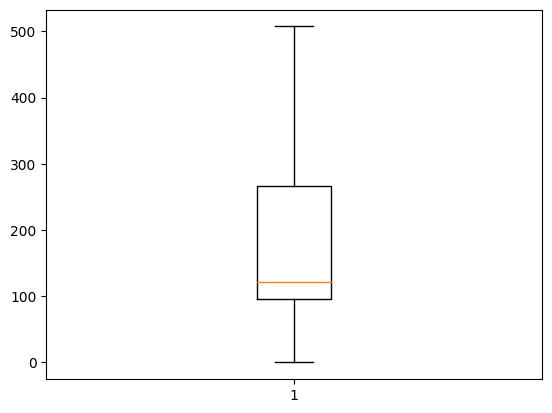

In [20]:
plt.boxplot(df['Power_kW'])
## Note: The high values are considered to be outliers, the small ones no! 
## No outliers

### Removing outliers

#### By zscore

In [21]:
z = np.abs(stats.zscore(df['Power_kW']))
print(z)

2017-01-01 00:00:00    0.933270
2017-01-01 01:00:00    0.930667
2017-01-01 02:00:00    0.939777
2017-01-01 03:00:00    0.944233
2017-01-01 04:00:00    0.931339
                         ...   
2018-12-31 19:00:00    0.701550
2018-12-31 20:00:00    0.855039
2018-12-31 21:00:00    0.859600
2018-12-31 22:00:00    0.879288
2018-12-31 23:00:00    0.931433
Name: Power_kW, Length: 17520, dtype: float64


In [22]:
threshold = 3 # 3 sigma...Includes 99.7% of the data

print(np.where(z > 3))

(array([4070, 4071, 4094], dtype=int64),)


In [23]:
df2 = df[(z<3)] #one way of excluding data abnormalties 

#### By IQR

In [24]:
Q1 = df['Power_kW'].quantile(0.25)
print(Q1)

Q3 = df['Power_kW'].quantile(0.75)
print(Q3)

IQR = Q3 - Q1 #interquartile range
print(IQR)

95.907157775
266.68080940000004
170.77365162500004


In [25]:
df3 = df[((df['Power_kW'] > (Q1 - 1.5 * IQR)) & (df['Power_kW'] < (Q3 + 1.5 * IQR)))] # another way of excluding outliers
df = df3 

In [26]:
df.describe()

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
count  17520.000000         17520.000000             17520.000000   
mean     173.799188            16.671524                71.994692   
std      105.976077             5.561856                17.064924   
min        0.000000             2.300000                14.000000   
25%       95.907158            12.600000                60.000000   
50%      121.014087            16.000000                75.000000   
75%      266.680809            20.000000                86.000000   
max      507.359512            40.500000               100.000000   

       precipitation (mm)  direct_radiation (W/m²)  windspeed_10m (m/s)  \
count        17520.000000             17520.000000         17520.000000   
mean             0.054697               150.947603             4.829596   
std              0.289908               229.617914             2.155795   
min              0.000000                 0.000000             0.100000   
25%              0.000000                 0.000000             3.200000   
50%              0.000000                 2.000000             4.610000   
75%              0.000000               253.250000             6.320000   
max              9.800000               899.000000            15.670000   

       windgusts_10m (m/s)          Hour       Day off  
count         17520.000000  17520.000000  17520.000000  
mean              8.352089     11.500000      0.300000  
std               3.521206      6.922384      0.458271  
min               1.100000      0.000000      0.000000  
25%               5.700000      5.750000      0.000000  
50%               7.900000     11.500000      0.000000  
75%              10.700000     17.250000      1.000000  
max              28.000000     23.000000      1.000000

In [27]:
fig = px.line(df, x = df.index.date, y = df['Power_kW'])
fig.show() #plotting power without outliers

## Feature Engineering

#### Creating a feature

In [28]:
df['Power-1']=df['Power_kW'].shift(1) # Column with previous hour consumption
df = df.dropna() # Errases previously NaN line created
df.head()

Power_kW  temperature_2m (°C)  relativehumidity_2m (%)  \
2017-01-01 01:00:00  75.173557                  7.3                     92.0   
2017-01-01 02:00:00  74.208175                  7.0                     92.0   
2017-01-01 03:00:00  73.735889                  6.8                     92.0   
2017-01-01 04:00:00  75.102351                  6.1                     94.0   
2017-01-01 05:00:00  75.787300                  5.7                     95.0   

                     precipitation (mm)  direct_radiation (W/m²)  \
2017-01-01 01:00:00                 0.0                      0.0   
2017-01-01 02:00:00                 0.0                      0.0   
2017-01-01 03:00:00                 0.0                      0.0   
2017-01-01 04:00:00                 0.0                      0.0   
2017-01-01 05:00:00                 0.0                      0.0   

                     windspeed_10m (m/s)  windgusts_10m (m/s)  Hour  Day off  \
2017-01-01 01:00:00                 2.30                  4.3     1        1   
2017-01-01 02:00:00                 2.20                  4.3     2        1   
2017-01-01 03:00:00                 2.20                  4.4     3        1   
2017-01-01 04:00:00                 2.10                  4.6     4        1   
2017-01-01 05:00:00                 2.01                  4.5     5        1   

                       Power-1  
2017-01-01 01:00:00  74.897706  
2017-01-01 02:00:00  75.173557  
2017-01-01 03:00:00  74.208175  
2017-01-01 04:00:00  73.735889  
2017-01-01 05:00:00  75.102351

In [29]:
df=df.iloc[:, [0,9,1,8,7,4,2,3,5,6]] # Change the position of the columns so that Y=column 0 and X all the remaining columns
df.head()

Power_kW    Power-1  temperature_2m (°C)  Day off  Hour  \
2017-01-01 01:00:00  75.173557  74.897706                  7.3        1     1   
2017-01-01 02:00:00  74.208175  75.173557                  7.0        1     2   
2017-01-01 03:00:00  73.735889  74.208175                  6.8        1     3   
2017-01-01 04:00:00  75.102351  73.735889                  6.1        1     4   
2017-01-01 05:00:00  75.787300  75.102351                  5.7        1     5   

                     direct_radiation (W/m²)  relativehumidity_2m (%)  \
2017-01-01 01:00:00                      0.0                     92.0   
2017-01-01 02:00:00                      0.0                     92.0   
2017-01-01 03:00:00                      0.0                     92.0   
2017-01-01 04:00:00                      0.0                     94.0   
2017-01-01 05:00:00                      0.0                     95.0   

                     precipitation (mm)  windspeed_10m (m/s)  \
2017-01-01 01:00:00                 0.0                 2.30   
2017-01-01 02:00:00                 0.0                 2.20   
2017-01-01 03:00:00                 0.0                 2.20   
2017-01-01 04:00:00                 0.0                 2.10   
2017-01-01 05:00:00                 0.0                 2.01   

                     windgusts_10m (m/s)  
2017-01-01 01:00:00                  4.3  
2017-01-01 02:00:00                  4.3  
2017-01-01 03:00:00                  4.4  
2017-01-01 04:00:00                  4.6  
2017-01-01 05:00:00                  4.5

In [30]:
# Define input and outputs
Z=df.values

Y=Z[:,0] # Y is the zeroth column (Power)
X=Z[:,[1, 2, 3, 4, 5, 6, 7, 8, 9]] # X are the remaining columns

## Feature Selection

### Filter Methods

#### K-Best

##### f_regression test

[2.19163982e+05 1.27422965e+03 1.52252910e+03 7.40709828e+02
 5.70314232e+03 2.80357036e+03 1.08534349e+01 4.87439213e+01
 1.74857813e+02]
[[74.897706   0.        92.       ]
 [75.1735565  0.        92.       ]
 [74.2081752  0.        92.       ]
 ...
 [83.1881112  0.        86.       ]
 [82.7047524  0.        86.       ]
 [80.6184063  0.        87.       ]]


<BarContainer object of 9 artists>

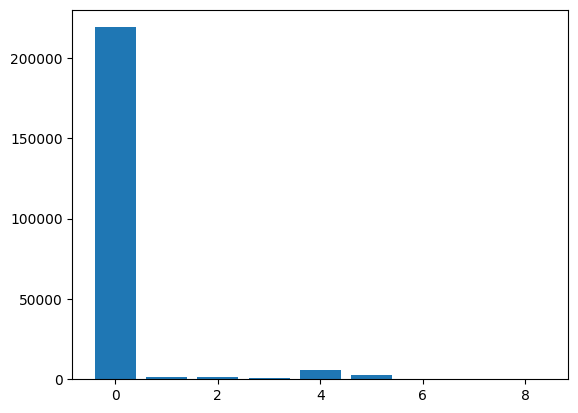

In [31]:
#features=SelectKBest(k=2,score_func=f_regression) # Test different k number of features, uses f-test ANOVA
features=SelectKBest(k=3, score_func = f_regression)

fit=features.fit(X, Y) #calculates the scores using the score_function f_regression of the features
print(fit.scores_)
features_results = fit.transform(X)
print(features_results) # k=0:Power-1 k=4:day_of_week and k=1:Temperature

plt.bar([i for i in range(len(fit.scores_))], fit.scores_)

##### mutual_info_regression test

[1.59875379 0.08396424 0.05580665 0.50882322 0.25080056 0.09276506
 0.00565371 0.02128727 0.03767809]
[[74.897706   1.         0.       ]
 [75.1735565  2.         0.       ]
 [74.2081752  3.         0.       ]
 ...
 [83.1881112 21.         0.       ]
 [82.7047524 22.         0.       ]
 [80.6184063 23.         0.       ]]


<BarContainer object of 9 artists>

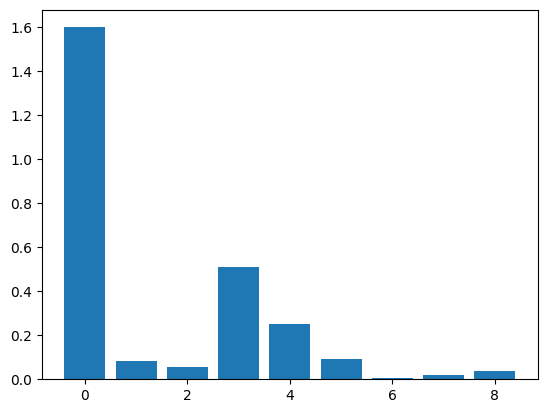

In [32]:
#features = SelectKBest(k=2, score_func = mutual_info_regression) # Test different k number of features, uses f-test ANOVA
features=SelectKBest(k=3,score_func=mutual_info_regression) # Test different k number of features, uses f-test ANOVA

fit=features.fit(X, Y) #calculates the f_regression of the features
print(fit.scores_)
features_results=fit.transform(X)
print(features_results) # k=0:Power-1, k=3:Hour  and k=4:Day_of_week /k=1:Tempeature

plt.bar([i for i in range(len(fit.scores_))], fit.scores_)

### Wrapper methods 

#### Recursive Feature Elimination (RFE)

In [33]:
model=LinearRegression() # LinearRegression Model as Estimator
rfe1=RFE(model,n_features_to_select=1)# using 1 features
rfe2=RFE(model,n_features_to_select=2) # using 2 features
rfe3=RFE(model,n_features_to_select=3)# using 3 features
rfe4=RFE(model,n_features_to_select=4)# using 4 features
fit1=rfe1.fit(X,Y)
fit2=rfe2.fit(X,Y)
fit3=rfe3.fit(X,Y)
fit4=rfe4.fit(X,Y)

In [34]:
print( "Feature Ranking (Linear Model, 1 features): %s" % (fit1.ranking_)) #direct_radiation (W/m²) 
print( "Feature Ranking (Linear Model, 2 features): %s" % (fit2.ranking_)) #direct_radiation (W/m²), windspeed_10m (m/s)
print( "Feature Ranking (Linear Model, 3 features): %s" % (fit3.ranking_)) #direct_radiation (W/m²), windspeed_10m (m/s),
                                                                           #windgusts_10m (m/s)
print( "Feature Ranking (Linear Model, 4 features): %s" % (fit4.ranking_)) # Power-1, Hour, windspeed, windgust

Feature Ranking (Linear Model, 1 features): [4 7 5 3 9 8 6 1 2]
Feature Ranking (Linear Model, 2 features): [3 6 4 2 8 7 5 1 1]
Feature Ranking (Linear Model, 3 features): [2 5 3 1 7 6 4 1 1]
Feature Ranking (Linear Model, 4 features): [1 4 2 1 6 5 3 1 1]


#### Removing non-features from dataframe

In [35]:
#Only the 4 features with highest score from feature ranking remain

df.drop(columns=['temperature_2m (°C)', 'relativehumidity_2m (%)', 'precipitation (mm)', 
                    'direct_radiation (W/m²)', 'Day off'], inplace=True)
df.head()

Power_kW    Power-1  Hour  windspeed_10m (m/s)  \
2017-01-01 01:00:00  75.173557  74.897706     1                 2.30   
2017-01-01 02:00:00  74.208175  75.173557     2                 2.20   
2017-01-01 03:00:00  73.735889  74.208175     3                 2.20   
2017-01-01 04:00:00  75.102351  73.735889     4                 2.10   
2017-01-01 05:00:00  75.787300  75.102351     5                 2.01   

                     windgusts_10m (m/s)  
2017-01-01 01:00:00                  4.3  
2017-01-01 02:00:00                  4.3  
2017-01-01 03:00:00                  4.4  
2017-01-01 04:00:00                  4.6  
2017-01-01 05:00:00                  4.5

### Esemble methods

[8.99702254e-01 3.00487961e-03 9.55283379e-04 8.90308054e-02
 1.69299545e-03 2.14753273e-03 2.68288693e-04 1.68862154e-03
 1.50933887e-03]


<BarContainer object of 9 artists>

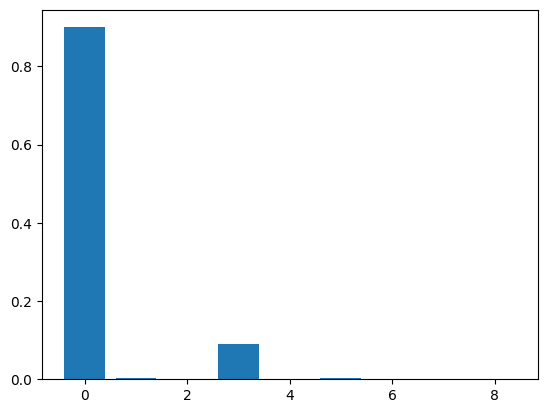

In [36]:
model = RandomForestRegressor()
model.fit(X, Y)
print(model.feature_importances_) # Power-1 hour Temp

plt.bar([i for i in range(len(model.feature_importances_))], model.feature_importances_)

### Saving file as csv

In [37]:
df.to_csv('IST_Alameda_DataHourly_Model.csv', encoding='utf-8', index=True)

## Class Regression

In [38]:
df_data=pd.read_csv('IST_Alameda_DataHourly_Model.csv')
df_data['Date'] = pd.to_datetime(df_data['Unnamed: 0']) # create a new column 'data time' of datetime type
df_data.drop(columns=["Unnamed: 0"], inplace=True)
df_data = df_data.set_index(['Date'], drop=True) # make 'datetime' into index
df_data.head()

Power_kW    Power-1  Hour  windspeed_10m (m/s)  \
Date                                                                   
2017-01-01 01:00:00  75.173557  74.897706     1                 2.30   
2017-01-01 02:00:00  74.208175  75.173557     2                 2.20   
2017-01-01 03:00:00  73.735889  74.208175     3                 2.20   
2017-01-01 04:00:00  75.102351  73.735889     4                 2.10   
2017-01-01 05:00:00  75.787300  75.102351     5                 2.01   

                     windgusts_10m (m/s)  
Date                                      
2017-01-01 01:00:00                  4.3  
2017-01-01 02:00:00                  4.3  
2017-01-01 03:00:00                  4.4  
2017-01-01 04:00:00                  4.6  
2017-01-01 05:00:00                  4.5

In [39]:
#The frequency of decomposition must be an interval, which 'may' repeat. 
#We have data with 1 hour frequency and we are looking for a daily repetition of behavior.
#So the frequency is 24h
freq = 24
#freq=24*7

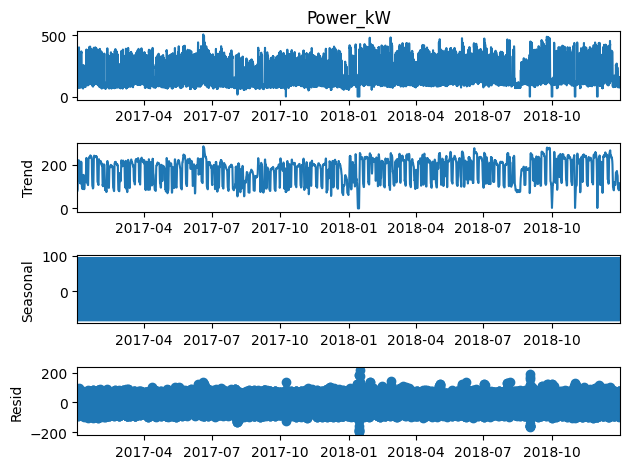

In [40]:
res = sm.tsa.seasonal_decompose(df_data['Power_kW'],
                                period=freq,
                                model='additive')
#model='additive', 'multiplicative'
resplot = res.plot()
#resplot.savefig('Seasonal_Decompose.png')

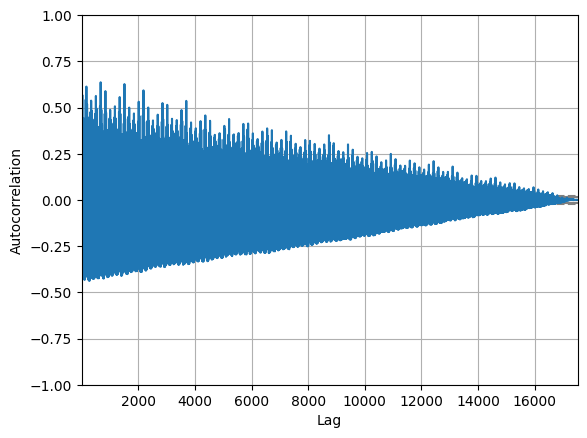

In [41]:
autocorrelation_plot(df_data['Power_kW'])
plt.show()

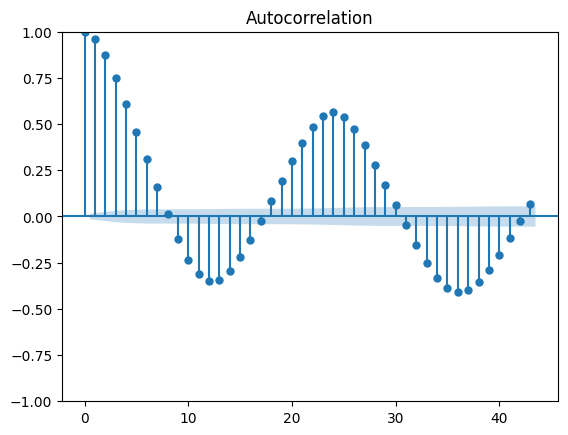

In [42]:
plot_acf(df_data['Power_kW'])
plt.show()

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



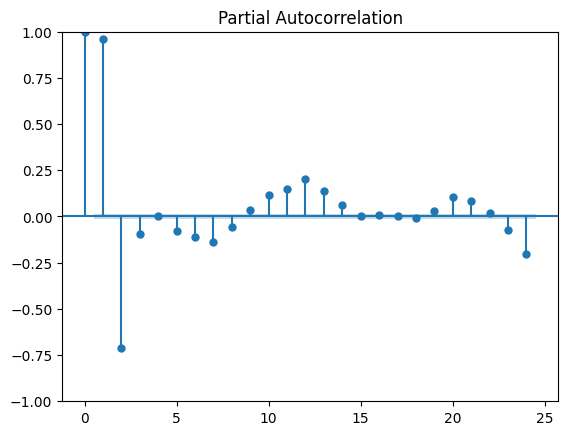

In [43]:
plot_pacf(df_data['Power_kW'],lags=24) # one day=24 lags / one week 24*7=168 lags
plt.show()

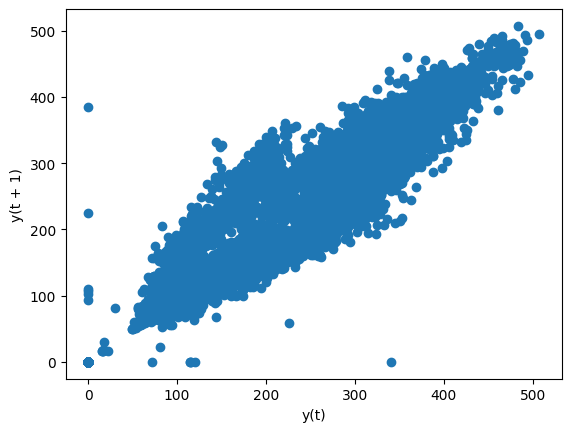

In [44]:
lag_plot(df_data['Power_kW'])
plt.show()

### AutoRegressive  Models 

#### ARX

In [45]:
from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.arima.model import ARIMA

#Identify output Y
Y=df_data.values[:,0]

split_point = len(Y) - 1000
train, test = Y[0:split_point], Y[split_point:]
# train autoregression
window = 5
model = AutoReg(train, lags=window)
#model=ARIMA(train, order=(1, 1,1))
model_fit = model.fit()

print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                16519
Model:                     AutoReg(5)   Log Likelihood              -73047.600
Method:               Conditional MLE   S.D. of innovations             20.175
Date:                Mon, 03 Apr 2023   AIC                         146109.199
Time:                        23:48:22   BIC                         146163.183
Sample:                             5   HQIC                        146127.026
                                16519                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2638      0.344     38.607      0.000      12.590      13.937
y.L1           1.5776      0.008    203.348      0.000       1.562       1.593
y.L2          -0.5590      0.014    -38.584      0.0

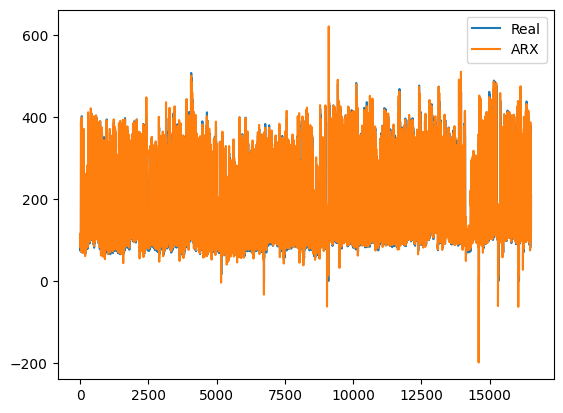

In [46]:
#model_fit.plot_predict()
plt.plot(train,label='Real')
plt.plot(model_fit.fittedvalues,label='ARX')
plt.legend()

#### Testing the ARX model with test data 

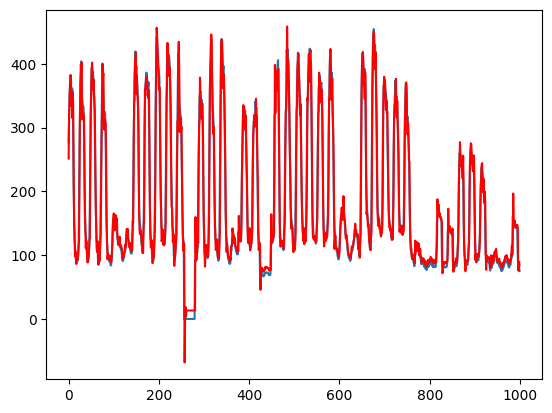

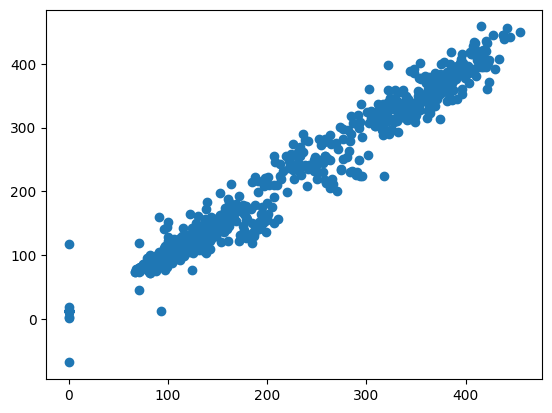

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt

coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

plt.scatter(test,predictions)
plt.show()

#### Evaluating the model error 

In [48]:
MAE_AR=metrics.mean_absolute_error(test,predictions) 
MBE_AR=np.mean(test-predictions) #here we calculate MBE
MSE_AR=metrics.mean_squared_error(test,predictions)  
RMSE_AR= np.sqrt(metrics.mean_squared_error(test,predictions))
cvRMSE_AR=RMSE_AR/np.mean(test)
NMBE_AR=MBE_AR/np.mean(test)
print(MAE_AR, MBE_AR,MSE_AR, RMSE_AR,cvRMSE_AR,NMBE_AR)

13.033315957670222 0.8158134194348302 371.2193118792295 19.267052495886066 0.10417833937133626 0.004411161867738683


In [49]:
df.head()

Power_kW    Power-1  Hour  windspeed_10m (m/s)  \
2017-01-01 01:00:00  75.173557  74.897706     1                 2.30   
2017-01-01 02:00:00  74.208175  75.173557     2                 2.20   
2017-01-01 03:00:00  73.735889  74.208175     3                 2.20   
2017-01-01 04:00:00  75.102351  73.735889     4                 2.10   
2017-01-01 05:00:00  75.787300  75.102351     5                 2.01   

                     windgusts_10m (m/s)  
2017-01-01 01:00:00                  4.3  
2017-01-01 02:00:00                  4.3  
2017-01-01 03:00:00                  4.4  
2017-01-01 04:00:00                  4.6  
2017-01-01 05:00:00                  4.5

### Split Data into training and test data 

#### Create vector with inputs and outputs

In [50]:
#Create matrix from data frame
Z=df_data.values
#Identify output Y
Y=Z[:,0]
#Identify input Y
X=Z[:,[1,2,3,4]] #power-1, hour, windspeed, windgust
#X2=Z[:,[1,2,4]]

In [51]:
#by default, it chooses randomly 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X,Y)
print(X_train)
print(y_train)

[[149.2330206  20.          2.66        4.3      ]
 [132.784313   21.          2.06        4.5      ]
 [ 93.9002738   3.          2.5         3.6      ]
 ...
 [262.6696186  10.          4.37        5.9      ]
 [ 86.6260293   1.          2.28        5.1      ]
 [ 92.7157393  10.          3.62        5.1      ]]
[150.8783877 125.5293494  93.7935607 ... 290.4159791  83.3950468
  95.9587485]


### Linear Regression

In [52]:
from sklearn import  linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)

# Make predictions using the testing set
y_pred_LR = regr.predict(X_test)

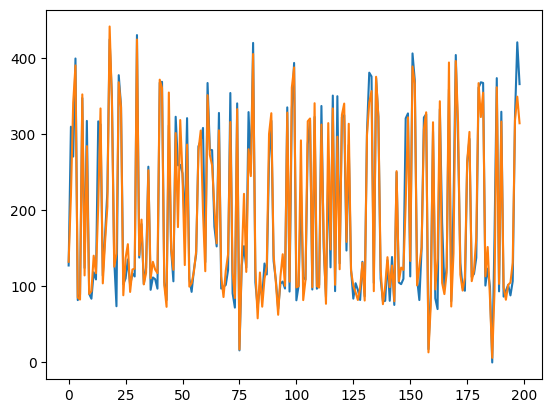

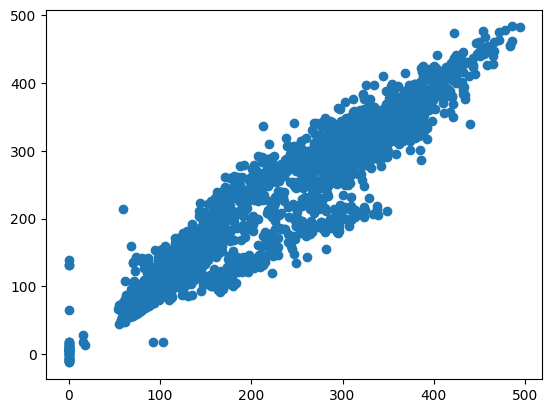

In [53]:
plt.plot(y_test[1:200])
plt.plot(y_pred_LR[1:200])
plt.show()
plt.scatter(y_test,y_pred_LR)

In [54]:
#Evaluate errors

#MAE_LR=metrics.mean_absolute_error(y_test,y_pred_LR) 
#MBE_SVR=np.mean(y_test- y_pred_SVR) #here we calculate MBE
#MSE_SVR=metrics.mean_squared_error(y_test,y_pred_LR)  
#RMSE_SVR= np.sqrt(metrics.mean_squared_error(y_test,y_pred_LR))
#cvRMSE_SVR=RMSE_SVR/np.mean(y_test)
#NMBE_SVR=MBE_SVR/np.mean(y_test)
#print(MAE_SVR, MBE_SVR,MSE_SVR, RMSE_SVR,cvRMSE_SVR,NMBE_SVR)

### Support Vector Regressor

#### Scale data 

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

ss_X = StandardScaler()
ss_y = StandardScaler()
X_train_ss = ss_X.fit_transform(X_train)
y_train_ss = ss_y.fit_transform(y_train.reshape(-1,1))

In [56]:
regr = SVR(kernel='rbf')
#kernel='linear'
#kernel='sigmoid'
#kernel='rbf'

regr.fit(X_train_ss,y_train_ss)

C:\Users\eduar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR()

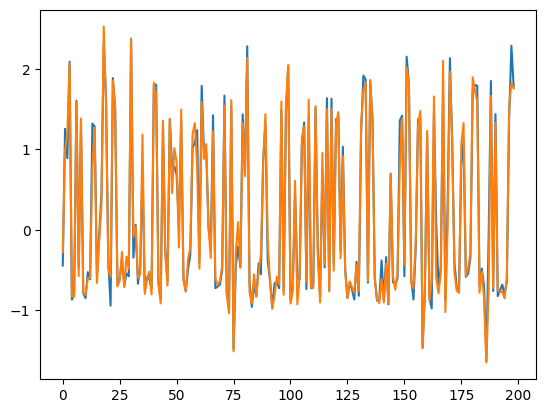

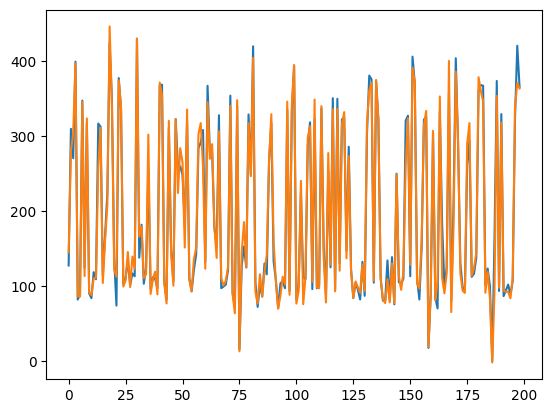

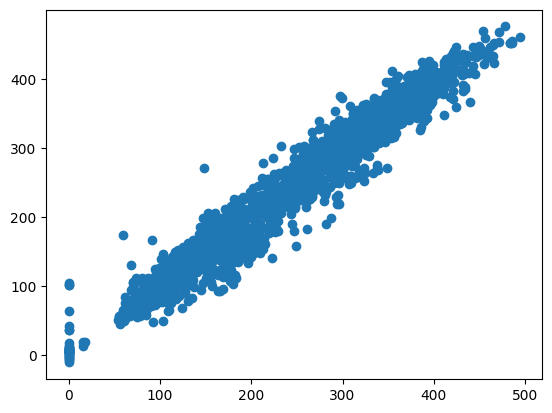

In [57]:
y_pred_SVR = regr.predict(ss_X.fit_transform(X_test))
y_test_SVR=ss_y.fit_transform(y_test.reshape(-1,1))#It is just one column we have to reshape, otherwise its a line
y_pred_SVR2=ss_y.inverse_transform(y_pred_SVR.reshape(-1,1))

plt.plot(y_test_SVR[1:200])
plt.plot(y_pred_SVR[1:200])
plt.show()
plt.plot(y_test[1:200])
plt.plot(y_pred_SVR2[1:200])
plt.show()
plt.scatter(y_test, y_pred_SVR2)

In [58]:
MAE_SVR=metrics.mean_absolute_error(y_test_SVR,y_pred_SVR) 
MBE_SVR=np.mean(y_test- y_pred_SVR) #here we calculate MBE
MSE_SVR=metrics.mean_squared_error(y_test_SVR,y_pred_SVR)  
RMSE_SVR= np.sqrt(metrics.mean_squared_error(y_test_SVR,y_pred_SVR))
cvRMSE_SVR=RMSE_SVR/np.mean(y_test)
NMBE_SVR=MBE_SVR/np.mean(y_test)
print(MAE_SVR, MBE_SVR,MSE_SVR, RMSE_SVR,cvRMSE_SVR,NMBE_SVR)

0.10612429708824897 174.94547093240607 0.024774542941669992 0.15739931048664094 0.0008997580354557357 1.0000589758071403


### Gaussian Process Regressor

Note: This process takes a very long time, it will not be used

In [59]:
#import sklearn.gaussian_process as gp

In [60]:
#kernel=gp.kernels.RBF(length_scale=1.0)
#RBF is radial basis function
#lenght_scale is a scale parameter of the RBF

In [61]:
#model = gp.GaussianProcessRegressor(kernel=kernel, alpha=0.1)
#alpha is the noise level

#### Non scaled data 

In [62]:
#by default, it chooses randomly 75% of the data for training and 25% for testing
#X2_train, X2_test, y2_train, y2_test = train_test_split(X2,Y)

In [63]:
#model.fit(X2_train, y2_train)
#params = model.kernel_.get_params()

In [64]:
#y2_pred_GPR, sigma = model.predict(X2_test, return_std=True)
#y2_pred_GPR = model.predict(X2_test)

In [65]:
#plt.plot(y2_test, 'b-')
#plt.plot(y2_pred_GPR, 'r-.', label='Prediction')
#plt.fill_between(y2_pred_GPR - sigma, y2_pred_GPR + sigma, alpha=0.1, color='blue')

#plt.xlabel('Input')
#plt.ylabel('Output')
#plt.title('Gaussian Process Regression')
#plt.legend()
#plt.show()
#plt.scatter(y2_test, y2_pred_GPR)

In [66]:
#MAE_GPR=metrics.mean_absolute_error(y2_test,y2_pred_GPR) 
#MBE_GPR=np.mean(y2_test- y2_pred_GPR) #here we calculate MBE
#MSE_GPR=metrics.mean_squared_error(y2_test,y2_pred_GPR)  
#RMSE_GPR= np.sqrt(metrics.mean_squared_error(y2_test,y2_pred_GPR))
#cvRMSE_GPR=RMSE_GPR/np.mean(y2_test)
#NMBE_GPR=MBE_SVR/np.mean(y2_test)
#print(MAE_GPR, MBE_GPR,MSE_GPR, RMSE_GPR,cvRMSE_GPR,NMBE_GPR)

### Decision Tree Regressor 

In [67]:
from sklearn.tree import DecisionTreeRegressor
#DecisionTreeRegressor(
#criterion='mse', 
#splitter='best', 
#max_depth=None, 
#min_samples_split=2, 
#min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, 
#max_features=None, 
#random_state=None, 
#max_leaf_nodes=None, 
#min_impurity_decrease=0.0, 
#min_impurity_split=None, 
#presort='deprecated', 
#ccp_alpha=0.0)

# Create Regression Decision Tree object
DT_regr_model = DecisionTreeRegressor()

# Train the model using the training sets
DT_regr_model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_DT = DT_regr_model.predict(X_test)

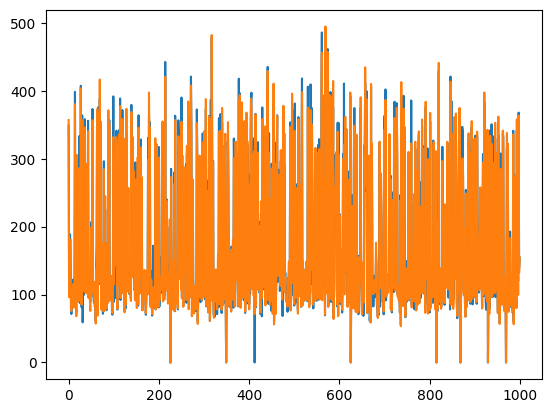

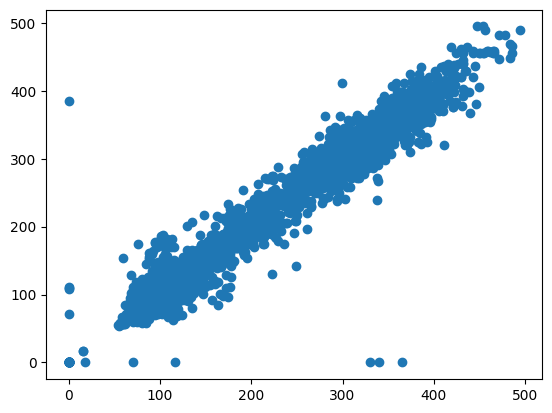

In [68]:
plt.plot(y_test[1000:2000])
plt.plot(y_pred_DT[1000:2000])
plt.show()
plt.scatter(y_test,y_pred_DT)

In [69]:
#Evaluate errors
MAE_DT=metrics.mean_absolute_error(y_test,y_pred_DT) 
MBE_DT=np.mean(y_test-y_pred_DT) #here we calculate MBE
MSE_DT=metrics.mean_squared_error(y_test,y_pred_DT)  
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_DT))
cvRMSE_DT=RMSE_DT/np.mean(y_test)
NMBE_DT=MBE_DT/np.mean(y_test)
print(MAE_DT, MBE_DT,MSE_DT, RMSE_DT,cvRMSE_DT,NMBE_DT)

11.35809362696347 -0.29229357125570776 414.0473797222967 20.348154209222436 0.11631826848437334 -0.0016708681164883373


### Random forest 

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 200, 
              'min_samples_split': 15,
              'max_features': 'sqrt',
              'max_depth': 20,
              'max_leaf_nodes': None}
RF_model = RandomForestRegressor(**parameters)
#RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)

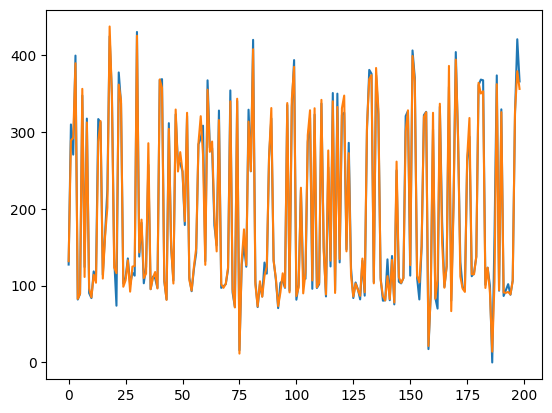

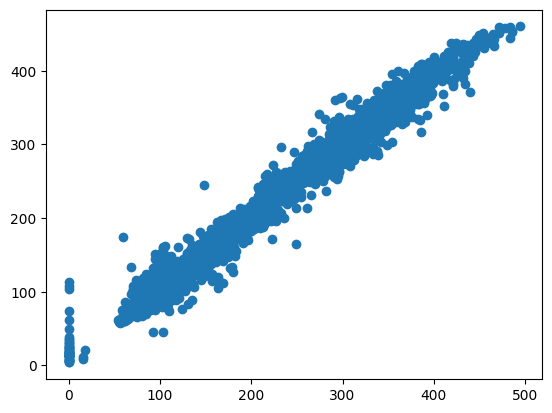

In [72]:
plt.plot(y_test[1:200])
plt.plot(y_pred_RF[1:200])
plt.show()
plt.scatter(y_test,y_pred_RF)

In [73]:
#Evaluate errors
MAE_RF=metrics.mean_absolute_error(y_test,y_pred_RF) 
MBE_RF=np.mean(y_test-y_pred_DT) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred_RF)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred_RF))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

8.426997672548742 -0.29229357125570776 173.3919752445671 13.167838670205795 0.07527268459100402 -0.0016708681164883373


### Uniformized data 

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random forest uniformized data 

In [75]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 100, 
              'min_samples_split': 15,
              'max_features': 'sqrt',
              'max_depth': 10,
              'max_leaf_nodes': None}

RF_model2 = RandomForestRegressor(**parameters)
RF_model2.fit(X_train_scaled, y_train.reshape(-1,1))
y_pred_RF2 = RF_model2.predict(X_test_scaled)

C:\Users\eduar\AppData\Local\Temp\ipykernel_15468\1225707402.py:10: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



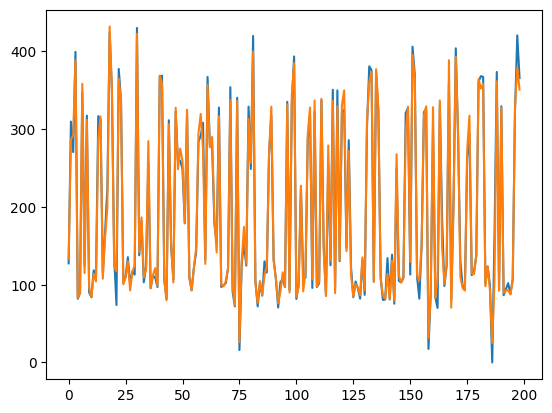

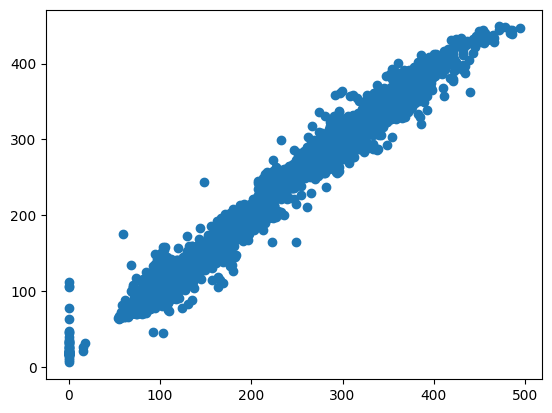

In [76]:
plt.plot(y_test[1:200])
plt.plot(y_pred_RF2[1:200])
plt.show()
plt.scatter(y_test,y_pred_RF2)

In [77]:
#Evaluate errors
MAE_RF=metrics.mean_absolute_error(y_test,y_pred_RF) 
MBE_RF=np.mean(y_test-y_pred_DT) #here we calculate MBE
MSE_RF=metrics.mean_squared_error(y_test,y_pred_RF)  
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test,y_pred_RF))
cvRMSE_RF=RMSE_RF/np.mean(y_test)
NMBE_RF=MBE_RF/np.mean(y_test)
print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)

8.426997672548742 -0.29229357125570776 173.3919752445671 13.167838670205795 0.07527268459100402 -0.0016708681164883373


### Gradient Boosting 

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
#GB_model = GradientBoostingRegressor(**params)

GB_model = GradientBoostingRegressor()
GB_model.fit(X_train, y_train)
y_pred_GB =GB_model.predict(X_test)

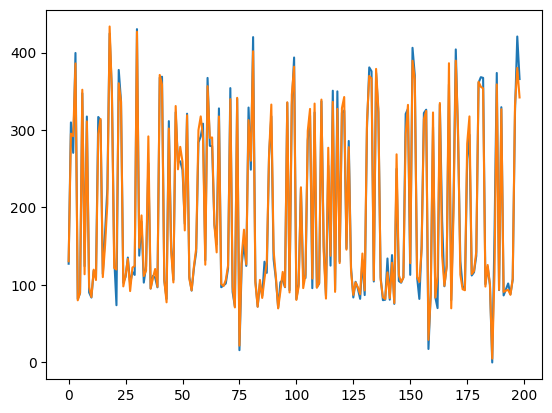

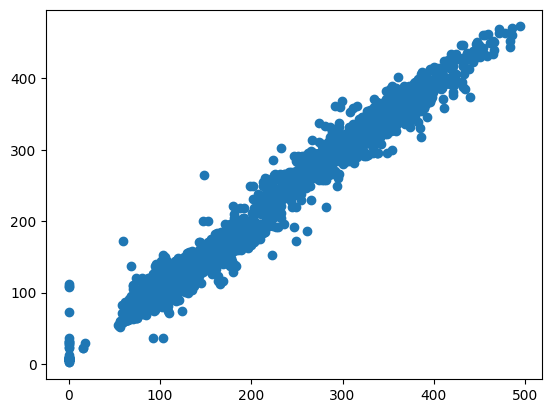

In [79]:
plt.plot(y_test[1:200])
plt.plot(y_pred_GB[1:200])
plt.show()
plt.scatter(y_test,y_pred_GB)

In [80]:
MAE_GB=metrics.mean_absolute_error(y_test,y_pred_GB) 
MBE_GB=np.mean(y_test-y_pred_GB)
MSE_GB=metrics.mean_squared_error(y_test,y_pred_GB)  
RMSE_GB= np.sqrt(metrics.mean_squared_error(y_test,y_pred_GB))
cvRMSE_GB=RMSE_GB/np.mean(y_test)
NMBE_GB=MBE_GB/np.mean(y_test)
print(MAE_GB,MBE_GB,MSE_GB,RMSE_GB,cvRMSE_GB,NMBE_GB)

8.723663251077616 -0.42461313097196013 181.5599229020536 13.474417349260545 0.07702521215371103 -0.002427260166330054


### Extreme Gradient Boosting 

In [81]:
from xgboost import XGBRegressor

#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
#GB_model = GradientBoostingRegressor(**params)

XGB_model = XGBRegressor()
XGB_model.fit(X_train, y_train)
y_pred_XGB =XGB_model.predict(X_test)

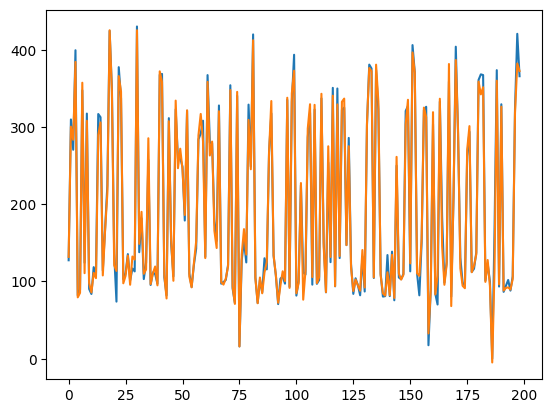

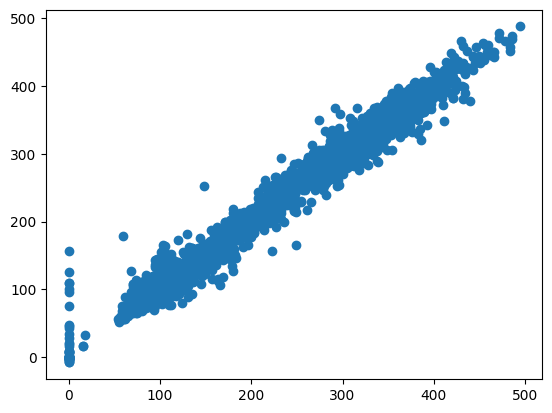

In [82]:
plt.plot(y_test[1:200])
plt.plot(y_pred_XGB[1:200])
plt.show()
plt.scatter(y_test,y_pred_XGB)

In [83]:
MAE_XGB=metrics.mean_absolute_error(y_test,y_pred_XGB) 
MBE_XGB=np.mean(y_test-y_pred_XGB)
MSE_XGB=metrics.mean_squared_error(y_test,y_pred_XGB)  
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test,y_pred_XGB))
cvRMSE_XGB=RMSE_XGB/np.mean(y_test)
NMBE_XGB=MBE_GB/np.mean(y_test)
print(MAE_XGB,MBE_XGB,MSE_XGB,RMSE_XGB,cvRMSE_XGB,NMBE_XGB)

8.544358535721297 -0.652999118244619 181.41879265768569 13.469179360959066 0.07699526969685204 -0.002427260166330054


### Bootstrapping 

In [84]:
from sklearn.ensemble import BaggingRegressor

BT_model = BaggingRegressor()
BT_model.fit(X_train, y_train)
y_pred_BT =BT_model.predict(X_test)

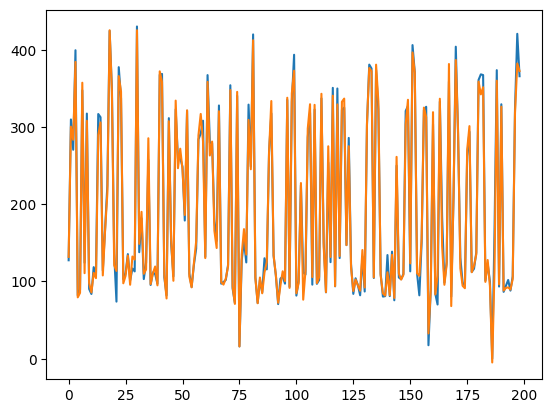

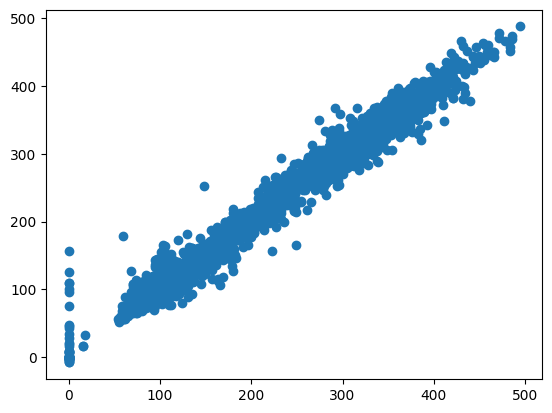

In [85]:
plt.plot(y_test[1:200])
plt.plot(y_pred_XGB[1:200])
plt.show()
plt.scatter(y_test,y_pred_XGB)

In [86]:
MAE_BT=metrics.mean_absolute_error(y_test,y_pred_BT) 
MBE_BT=np.mean(y_test-y_pred_BT)
MSE_BT=metrics.mean_squared_error(y_test,y_pred_BT)  
RMSE_BT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_BT))
cvRMSE_BT=RMSE_BT/np.mean(y_test)
NMBE_BT=MBE_BT/np.mean(y_test)
print(MAE_BT,MBE_BT,MSE_BT,RMSE_BT,cvRMSE_BT,NMBE_BT)

8.997702566136985 -0.3697948830319638 208.54129857162775 14.440959059966472 0.08255035497753935 -0.0021138969189236885


### Neural Networks 

In [87]:
from sklearn.neural_network import MLPRegressor

NN_model = MLPRegressor(hidden_layer_sizes=(5,10,5))
NN_model.fit(X_train,y_train)
y_pred_NN = NN_model.predict(X_test)

C:\Users\eduar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



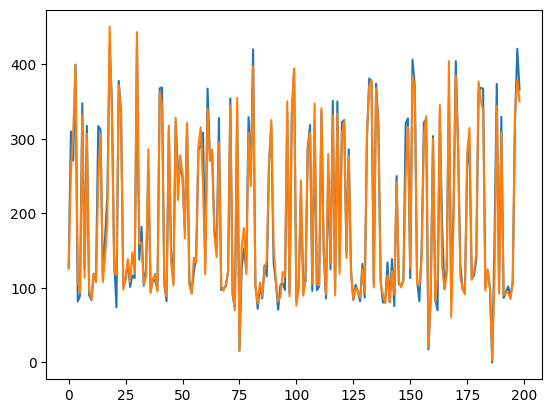

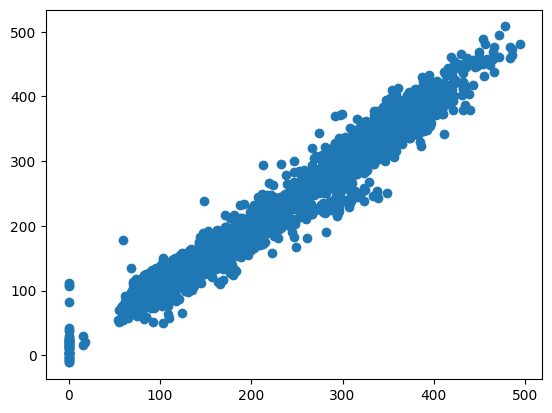

In [88]:
plt.plot(y_test[1:200])
plt.plot(y_pred_NN[1:200])
plt.show()
plt.scatter(y_test,y_pred_NN)

In [89]:
MAE_NN=metrics.mean_absolute_error(y_test,y_pred_NN)
MBE_NN=np.mean(y_test-y_pred_NN)
MSE_NN=metrics.mean_squared_error(y_test,y_pred_NN)  
RMSE_NN= np.sqrt(metrics.mean_squared_error(y_test,y_pred_NN))
cvRMSE_NN=RMSE_NN/np.mean(y_test)
NMBE_NN=MBE_NN/np.mean(y_test)
print(MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN)

12.173685646781356 0.3798342674180132 314.21116771257226 17.7260025869504 0.10132899067223959 0.0021712860951815065


# Save model


The best model was 'Random Forest', so this will be the one used

In [90]:
import pickle

In [91]:
#save RF model
with open('RF_model.pkl','wb') as file:
    pickle.dump(RF_model, file)
    
#save Bootstrapping model
with open('BT_model.pkl','wb') as file:
    pickle.dump(BT_model, file)
    
#save gradient boosting model
with open('GB_model.pkl','wb') as file:
    pickle.dump(GB_model, file)
    
#save linear regression model
with open('regr.pkl','wb') as file:
    pickle.dump(regr, file)
    
#save neural networks model
with open('NN_model.pkl','wb') as file:
    pickle.dump(NN_model, file)
    
#save extreme gradient boosting model
with open('XGB_model.pkl','wb') as file:
    pickle.dump(XGB_model, file)

### Load model and use it

In [92]:
#Load RF model
with open('RF_model.pkl','rb') as file:
    RF_model=pickle.load(file)

#### Adjusting test file (2019)

In [93]:
df_power_2019 = pd.read_csv('testData_2019_Central.csv') #Open test file
df_power_2019['Date'] = pd.to_datetime(df_power_2019['Date']) # Convert Date into datetime type
df_power_2019 = df_power_2019.set_index(df_power_2019['Date'], drop = True) # set date as index
df_power_2019.drop(columns=["Date"], inplace=True) #remove 'Date' column

df_power_2019['Hour']=df_power_2019.index.hour #Column with respective hour
df_power_2019['Power-1']=df_power_2019['Central (kWh)'].shift(1) # Column with previous hour consumption
df_power_2019 = df_power_2019.dropna() # Errases previously NaN created

df_power_2019.drop(columns=['temp_C', 'HR','pres_mbar', 'solarRad_W/m2', 
                            'rain_mm/h', 'rain_day'], inplace=True) #remove non-features

df_power_2019=df_power_2019.iloc[:, [0, 4, 3, 1, 2]] # Change the position of the columns so that Y=column 0 and X all the remaining columns


df_power_2019.head()

Central (kWh)  Power-1  Hour  windSpeed_m/s  windGust_m/s
Date                                                                          
2019-01-01 01:00:00        122.528  121.829     1            0.0           0.0
2019-01-01 02:00:00        121.191  122.528     2            0.0           0.0
2019-01-01 03:00:00        120.859  121.191     3            0.0           0.0
2019-01-01 04:00:00        120.500  120.859     4            0.0           0.0
2019-01-01 05:00:00        120.677  120.500     5            0.0           0.0

In [94]:
Z=df_power_2019.values
X_2019=Z[:,[1,2,3,4]] #features selected

In [95]:
y_test = Z[:, 0]
y2_pred_RF = RF_model.predict(X_2019)

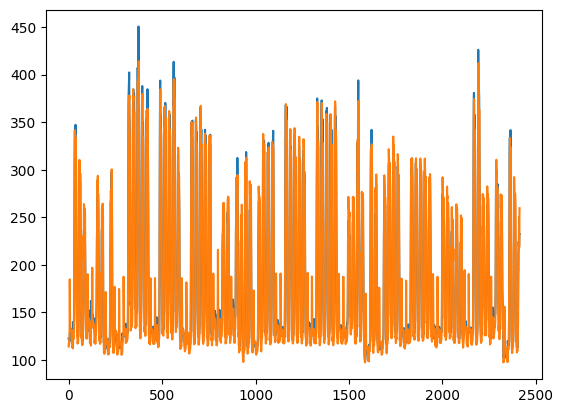

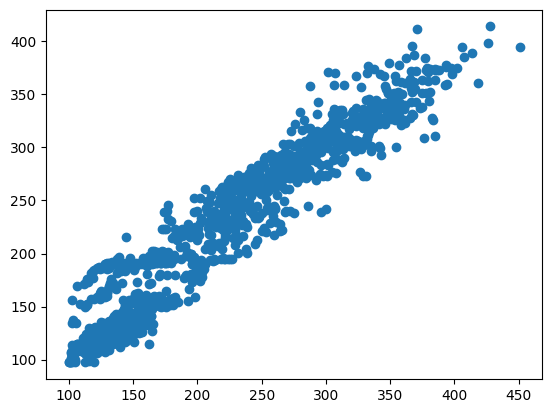

In [96]:
plt.plot(y_test)
plt.plot(y2_pred_RF)
plt.show()
plt.scatter(y_test,y2_pred_RF)

In [97]:
MAE_NN=metrics.mean_absolute_error(y_test,y2_pred_RF)
MBE_NN=np.mean(y_test-y2_pred_RF)
MSE_NN=metrics.mean_squared_error(y_test,y2_pred_RF)  
RMSE_NN= np.sqrt(metrics.mean_squared_error(y_test,y2_pred_RF))
cvRMSE_NN=RMSE_NN/np.mean(y_test)
NMBE_NN=MBE_NN/np.mean(y_test)
print(MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN)

13.515029548767894 0.48455452628413126 342.49445766929523 18.506605784673084 0.10209788603142403 0.002673207252382277
